In [16]:
# Import libraries
import requests
from zipfile import ZipFile
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import datetime
import time
import glob
import contextlib
from PIL import Image

In [17]:
# Set interval (minutes)
interval = 1

# Set runtime (minutes)
runtime = 180

# Calculate interval in seconds and number of iterations to perform
iterations = int(runtime/interval)
interval = interval*60

In [4]:
# Download map data (Approx. 400MB)
mapurl = 'http://download.geofabrik.de/europe/great-britain/scotland-latest-free.shp.zip'
req = requests.get(mapurl, allow_redirects=True)
open('scotland-latest-free.shp.zip', 'wb').write(req.content)

421918767

In [18]:
# Extract necessary files from downloaded zip file
with ZipFile('scotland-latest-free.shp.zip', 'r') as zObject:
    zObject.extract('gis_osm_roads_free_1.cpg', path='scotland-latest-free.shp')
    zObject.extract('gis_osm_roads_free_1.dbf', path='scotland-latest-free.shp')
    zObject.extract('gis_osm_roads_free_1.prj', path='scotland-latest-free.shp')
    zObject.extract('gis_osm_roads_free_1.shp', path='scotland-latest-free.shp')
    zObject.extract('gis_osm_roads_free_1.shx', path='scotland-latest-free.shp')
zObject.close()

In [19]:
# Request JSON for station information
stationsurl = 'https://gbfs.nextbike.net/maps/gbfs/v1/nextbike_gg/en/station_information.json'
req = requests.get(stationsurl)
print(req)

# Extract stations from JSON
jsondata = json.loads(req.text)
stations = jsondata['data']['stations']

# Convert JSON to dataframe
data = []
for station in stations:
    stationdata = []
    stationdata.append(station['station_id'])
    stationdata.append(station['name'])
    stationdata.append(station['short_name'])
    stationdata.append(station['lat'])
    stationdata.append(station['lon'])
    stationdata.append(station['region_id'])
    try:
        stationdata.append(station['capacity'])
    except:
        stationdata.append(4)
    data.append(stationdata)
    
data = pd.DataFrame(data, columns=['station_id', 'name', 'short_name', 'lat', 'lon', 'region_id', 'capacity'])

# Convert to geodataframe
geometry = [Point(xy) for xy in zip(data['lon'], data['lat'])]
data = gpd.GeoDataFrame(data, crs='epsg:4326', geometry=geometry)
data.head()

<Response [200]>


,station_id,name,short_name,lat,lon,region_id,capacity,geometry
0,264283,Waterloo Street - ELECTRIC,8402,55.860770,-4.264535,237,4,POINT (-4.26454 55.86077)
1,264292,George Square - ELECTRIC,8406,55.861550,-4.249400,237,10,POINT (-4.24940 55.86155)
2,264293,Merchant Square - ELECTRIC,8407,55.858167,-4.245483,237,8,POINT (-4.24548 55.85817)
3,264294,St George's Cross - ELECTRIC,8408,55.871367,-4.269117,237,10,POINT (-4.26912 55.87137)
4,264295,St Enoch Square - ELECTRIC,8410,55.856859,-4.255593,237,10,POINT (-4.25559 55.85686)


In [20]:
# Read roads data
roads = gpd.read_file('scotland-latest-free.shp/gis_osm_roads_free_1.shp')

# Filter minor roads
roads = roads[~roads['fclass'].isin(['residential', 'footway', 'cycleway', 'bridleway', 'busway',
                                     'track_grade1', 'track_grade2', 'track_grade3', 'track_grade4',
                                     'track_grade5', 'track_grade6', 'path', 'track', 'steps', 'unknown',
                                     'service'])]
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
1,370,5131,motorway_link,None,M9,F,112,0,F,F,"LINESTRING (-3.41038 55.94936, -3.40838 55.94752)"
2,375,5131,motorway_link,None,M8,F,112,0,F,F,"LINESTRING (-3.30997 55.92267, -3.31006 55.922..."
19,1665,5135,tertiary_link,City of Edinburgh Bypass,A720,F,64,0,F,F,"LINESTRING (-3.31948 55.93824, -3.32022 55.938..."
20,1708,5131,motorway_link,None,M8,F,80,0,F,F,"LINESTRING (-3.40070 55.93516, -3.40098 55.935..."
21,1709,5111,motorway,None,M9,F,80,0,F,F,"LINESTRING (-3.40070 55.93516, -3.40084 55.935..."


In [27]:
# Function to fetch and plot data
def fetchandplot(roads, data):
    # Request JSON
    liveurl = 'https://gbfs.nextbike.net/maps/gbfs/v1/nextbike_gg/en/station_status.json'
    req = requests.get(liveurl)

    # Generate filename from timestamp
    now = datetime.now()
    filename = 'plots/' + now.strftime("%Y%m%d %H%M%S") + '.png'

    # Extract stations from JSON
    jsondata = json.loads(req.text)
    stations = jsondata['data']['stations']

    # Convert JSON to dataframe
    livedata = []
    for station in stations:
        stationdata = []
        stationdata.append(station['station_id'])
        stationdata.append(station['num_bikes_available'])
        stationdata.append(station['num_docks_available'])
        stationdata.append(station['is_installed'])
        stationdata.append(station['is_renting'])
        stationdata.append(station['last_reported'])
        livedata.append(stationdata)

    livedata = pd.DataFrame(livedata, columns=['station_id', 'num_bikes_available', 'num_docks_available', 
                                               'is_installed', 'is_renting', 'last_reported'])
    livedata = livedata[['station_id', 'num_bikes_available']]

    # Merge livedata with stationsdata, calculate fill percent for each station
    livedata = livedata.merge(data, on='station_id')
    livedata['fillpercent'] = livedata['num_bikes_available']/livedata['capacity']*100
    livedata['fillpercent'] = livedata['fillpercent'].clip(upper=100)

    # Plot station fill percentages, save image
    fig, ax = plt.subplots(figsize=(12, 6))
    roads.plot(ax=ax, alpha=0.3, color='grey')
    data.plot(column=livedata['fillpercent'], cmap='coolwarm_r', markersize=100, ax=ax, legend=True)
    ax.set_xlim(-4.375, -4.125)
    ax.set_ylim(55.81, 55.9)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Ovo Bikes Available in Glasgow (as % of Bikes at Station). ' + now.strftime('Time: %H:%M'))
    fig.savefig(filename, dpi=400, bbox_inches='tight')

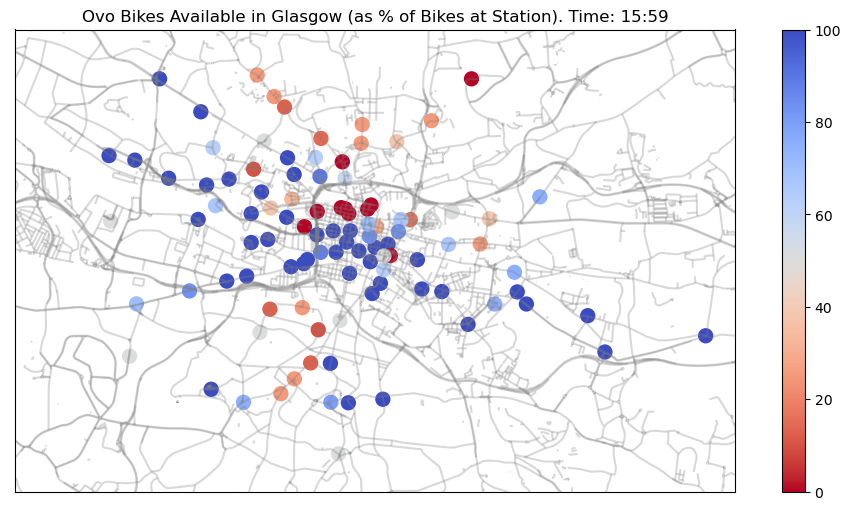

In [28]:
# Test working before running main loop
fetchandplot(roads, data)

In [ ]:
# Generate frames based on provided interval and runtime
frames = 0
while frames < iterations:
    fetchandplot(roads, data)
    frames += 1
    time.sleep(interval - time.time() % interval)

In [8]:
# Filepaths
fp_in = 'plots/*.png'
fp_out = 'plots/bikemovements.gif'

# Use ExitStack to automatically close opened images
with contextlib.ExitStack() as stack:
    # Load images
    images = (stack.enter_context(Image.open(f)) for f in sorted(glob.glob(fp_in)))
    # Extract first image from iterator
    image = next(images)
    # Save as gif
    image.save(fp=fp_out, format='gif', append_images=images, save_all=True, duration=100, loop=0)